In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [145]:
class GMM():
    def __init__(self, n_components, data):
        self.num_data = data.shape[0]
        self.dimension = data.shape[1]
        self.data = data
        self.components = n_components
        self.means = self.initialize_means()
        self.covariances = self.initialize_variances()
        self.lambdas = self.initialize_lambdas()
            
    
    def initialize_means(self): 
        random_choice = np.random.choice(self.num_data, self.components, replace = False)
        means_ = self.data[random_choice]
        return means_
        
    def initialize_variances(self):
        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            covariances_[i] = np.cov(self.data, rowvar = False)
        return covariances_    
    
    def initialize_lambdas(self):
        return np.ones([self.components]) / float(self.components)
        
        
    def initialize_gammas(self):
        """Initializes gammas to random values maintaining their sum = 1 for each component"""
        gammas_ = np.random.rand(self.components, self.num_data)
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
        
    def calculate_means(self):
        """Calculates the means based on the current values of gammas"""
#         print(self.num_data, self.components, self.dimension)
        means_ = np.zeros((self.components, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                means_[i] += self.gammas[i][j] * self.data[j] / self.gammas[i].sum()
        return means_
        
    def calculate_variances(self):
        """Calculates the covariances based on the current values of gammas"""

        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                covariances_[i] += self.gammas[i][j] * np.dot((self.data[j] - self.means[i]).reshape(-1, 1), (self.data[j] - self.means[i]).reshape(-1, 1).T) / self.gammas[i].sum()
                if np.log(np.linalg.det(covariances_[i])) < -800:
#                     print(np.power(np.e, -20))
#                     print("Entering {}".format(np.log(np.linalg.det(covariances_[i]))))
                    covariances_[i] = np.cov(self.data, rowvar = False) / 100.
                    self.means[i] = self.data[np.random.choice(self.num_data)]
        return covariances_
    
    def calculate_lambdas(self):
        """Updates lambdas based on the values of gamma"""
        return self.gammas.sum(1)/self.gammas.sum()
    
    def calculate_gammas(self):
        """Updates gammas based on the values of the means, covariances and lambdas"""
        gammas_ = np.zeros((self.components, self.num_data))
        for i in range(self.components):
            for j in range(self.num_data):
                gammas_[i, j] = self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
    
    def calculate_likelihood(self):
        """Calculates the likelihood of data given parameters. We need to stop EM when likelihood saturates"""
        prb = np.zeros((self.num_data))
        for j in range(self.num_data):
            for i in range(self.components):
                prb[j] += self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        likelihood_ = np.sum(np.log(prb))
#         print("Likelihood {}".format(likelihood_))
        return likelihood_
    
    def gaussian_probability(self, x_, mu_, sigma_):
        """Given the datapoint, mean for the component and the variance matrix of the component, calculates the probability"""
        x_ = x_.reshape(-1, 1)
        mu_ = mu_.reshape(-1, 1)

        prob_ = (1. / (np.power(2 * np.pi, self.dimension / 2.) * np.power(np.linalg.det(sigma_), 0.5))) * np.exp(- 0.5 * np.dot((x_ - mu_).T, np.dot(np.linalg.inv(sigma_), (x_ - mu_))))
        prob_ = float(prob_.reshape(1))
#         print(prob_)
        return prob_

    def EM(self, max_iter):
        likelihood_list = []
        converged = False
        for i in range(max_iter):
            self.gammas = self.calculate_gammas() # E STEP
            self.means = self.calculate_means() # M STEP
            self.covariances = self.calculate_variances() # M STEP
            self.lambdas = self.calculate_lambdas() # M STEP
            likelihood_list.append(self.calculate_likelihood()) #CALCULATE LIKELIHOOD
            if i % (max_iter / 20) == 0:
                print("Iteration {}, Log Likelihood {}".format(i, likelihood_list[-1]))
            if len(likelihood_list) > 10:
                for i in range(10, 5):
                    if likelihood_list[-i] <= likelihood_list[-1]:
                        print("Converged")
                        converged = True
            if converged:
                break
        return likelihood_list

### Data Preparation and Initialization

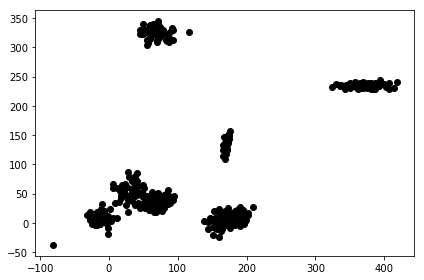

In [146]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data


# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [30, 50],
    [-15, 10],
    [70, 35],
    [70, 325],
    [170, 5],
    [370, 235],
    [170, 135],
    [-70, -35],
])

init_covariances = np.array([
    [[128.5, 0.], [0, 232.5]],
    [[75.92, 6.38], [6.38, 102.91]],
    [[105.5, 20.2], [20.2, 55.5]],
    [[175.92, 36.38], [36.38, 129.1]],
    [[275.92, 45.38], [45.38, 102.91]],
    [[375.92, 6.38], [6.38, 10.91]],
    [[5.92, 16.38], [16.38, 102.91]],
    [[35.92, 6.38], [6.38, 12.91]]
])

init_weights = [.1, .1, .25, .1, .2, .125, .12, .005]

# generate data
# np.random.seed(4)
X = generate_data(500, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()
plt.show()

### Initializing Model on the Data

In [153]:
X = np.random.rand(1000, 5) * 100

mod = GMM(5, X)

### Initial Parameters of the model

In [154]:
mod.covariances

array([[[ 776.92063492,   -3.99208987,  -12.32343989,    8.94565504,
           29.30223589],
        [  -3.99208987,  815.98104832,  -35.30023135,  -29.60724415,
          -18.49843923],
        [ -12.32343989,  -35.30023135,  832.4760742 ,   -2.02036375,
           31.42294878],
        [   8.94565504,  -29.60724415,   -2.02036375,  849.19201791,
           38.44282235],
        [  29.30223589,  -18.49843923,   31.42294878,   38.44282235,
          827.24037601]],

       [[ 776.92063492,   -3.99208987,  -12.32343989,    8.94565504,
           29.30223589],
        [  -3.99208987,  815.98104832,  -35.30023135,  -29.60724415,
          -18.49843923],
        [ -12.32343989,  -35.30023135,  832.4760742 ,   -2.02036375,
           31.42294878],
        [   8.94565504,  -29.60724415,   -2.02036375,  849.19201791,
           38.44282235],
        [  29.30223589,  -18.49843923,   31.42294878,   38.44282235,
          827.24037601]],

       [[ 776.92063492,   -3.99208987,  -12.32343989,   

In [155]:
mod.means

array([[ 62.09454449,  12.84856586,  89.34031956,  49.25481973,
         37.55779036],
       [ 17.78653263,  29.20563368,  62.87296748,  68.12640673,
         24.84392496],
       [ 13.68989847,  57.67898314,   2.15538247,  35.91521354,
         56.38174233],
       [ 55.2349227 ,  67.15491372,  68.50725287,  91.964073  ,
         98.18974159],
       [ 59.04968715,  79.64980319,  66.79471496,  13.43414944,
         23.95986566]])

In [156]:
mod.lambdas

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

### Running EM on the GMM

Log Likelihoods in every iteration are printed

In [157]:
likelihoods = mod.EM(500)

/home/krishanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log


Iteration 0, Log Likelihood -23786.2854183
Iteration 25, Log Likelihood -23600.967879
Iteration 50, Log Likelihood -23582.7281925
Iteration 75, Log Likelihood -23577.4992197
Iteration 100, Log Likelihood -23577.1301867
Iteration 125, Log Likelihood -23577.0169758
Iteration 150, Log Likelihood -23576.9783546
Iteration 175, Log Likelihood -23576.9648929
Iteration 200, Log Likelihood -23576.9602457
Iteration 225, Log Likelihood -23576.9586682
Iteration 250, Log Likelihood -23576.9581404
Iteration 275, Log Likelihood -23576.9579655
Iteration 300, Log Likelihood -23576.9579079
Iteration 325, Log Likelihood -23576.9578891
Iteration 350, Log Likelihood -23576.9578829
Iteration 375, Log Likelihood -23576.9578809
Iteration 400, Log Likelihood -23576.9578802
Iteration 425, Log Likelihood -23576.95788
Iteration 450, Log Likelihood -23576.9578799
Iteration 475, Log Likelihood -23576.9578799


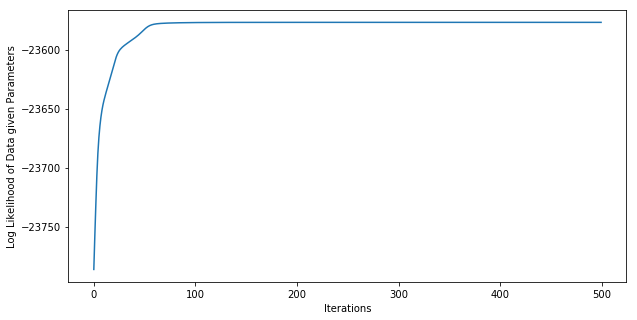

In [158]:
plt.figure(figsize=(10, 5))
plt.plot(likelihoods)
plt.ylabel("Log Likelihood of Data given Parameters")
plt.xlabel("Iterations")
plt.show()

### Model parameters after EM

In [46]:
mod.covariances

array([[[  87.58975968,   23.46067151],
        [  23.46067151,   54.92018212]],

       [[  58.75289432,    3.4938826 ],
        [   3.4938826 ,   96.48753419]],

       [[ 116.51234275,   -1.06365612],
        [  -1.06365612,  301.7242531 ]]])

In [11]:
mod.lambdas

array([ 0.24438138,  0.27053524,  0.48508338])

In [12]:
mod.means

array([[ 70.32781223,  34.25099333],
       [ 29.89440707,  50.00063523],
       [-15.65857873,   9.13675934]])